# Auswertung

In [1]:
#Benötigte Pakete
%matplotlib inline 
import numpy as np
import io
from decimal import Decimal
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chi2
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = 16, 9

In [2]:
def sig(val1,err1,val2,err2):
    sig = np.abs(val2-val1)**2/np.abs(np.abs(err2)+np.abs(err1))**2
    return round(sig,3)

def format_e(n):
    a = '%e' % Decimal(n)
    return a.split('e')[0].rstrip('0').rstrip('.')+'e'+a.split('e')[1]

def form(val,err):
        a = "{value:4.3f} ± {error:4.3f}".format(value=val,error=err)
        return a

def fitgüte(x,y,delta_x,delta_y,popt,fit_funktion):    
    chisquare=np.sum((fit_funktion(popt, x)-y)**2/
                     (delta_y**2+((fit_func(popt, x+delta_x)-fit_func(popt, x-delta_x))/2)**2))

    #Freiheitsgrade
    dof=dof = x.size-popt.size
    if dof == 0:
        chisquare_red = 'inf'
        prob = 100
    else:
        chisquare_red = chisquare/dof
        prob = round(1-chi2.cdf(chisquare,dof),3)*100 #Fitwahrscheinlichket

    print('chi_squared= ' + str(chisquare))#format_e(chisquare))
    print('chi_squared_red= ' + str(chisquare_red))#format_e(chisquare_red))
    print('Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten: ' +
          str(prob) + ' %')

## Teil 1: Kugelfallviskosimeter
### Wichtige Größen

In [3]:
g=9.81 # m/s**2
p0=1000.3 # hPa
dp0=0.2 # hPa
T = 23 # °C
dt = 0.5 # °C
D_rohr = 75*1e-3 # m
dD_rohr = 1*1e-3 # m
rho_Fl=1.1468e3 #kg/m**3
drho_Fl=0.0006e3 #kg/m**3

### Messgrößen

In [4]:
# Kugeln
d = np.array([1.5,2,3,4,5,6,7.144,8,9])*1e-3 # m
d_err = d*0.01 # Fehler 1%

rho_K = np.array([1.390,1.375,1.375,1.375,1.375,1.375,1.375,1.355,1.360])*1e3 #kg/m^3
drho_K = np.ones(rho_K.size)*0.005 #kg/m^3

# Messwerte für Geschwindigkeiten
T = np.array([np.array([31.56,29.58,31.70,31.81,31.54]), # sec
              np.array([41.37,40.31,40.37,38.32,37.90]),
              np.array([10.14, 9.92,10.23, 9.67, 9.87]),
              np.array([12.24,11.67,11.90,12.32,11.54]),
              np.array([15.18,15.54,16.17,15.95,15.46]),
              np.array([11.65,11.50,11.50,11.07,11.07]),
              np.array([ 8.39, 8.31, 8.36, 8.20 ,8.70]),
              np.array([ 7.67, 7.50, 7.70, 7.43, 8.04]),
              np.array([ 5.89, 5.92, 6.00, 5.93, 5.95]),])

t = np.ones(len(T))
dt_sys = 0.3 # sec
dt = np.ones(len(T))

for i in range(0,len(T),1):
    t[i] = np.mean(T[i])
    dt[i] = np.std(T[i]) + dt_sys # stat. Fehler + syst. Fehler

s = np.array([50,100,50,100,200,200,200,200,200])*1e-3 # m
ds = 0.002 # m

### Berechnung der Terminalgeschwindigkeiten $v_\text{te}$

Die Terminalgeschwindigkeit $v_{te}$ ergibt sich aus:

\begin{align}
    v_\text{te} &= \frac{s}{t}\\
    \Delta v_\text{te} &= \sqrt{\left(\frac{1}{t} \Delta s\right)^2 + \left(\frac{s}{t^2} \Delta t\right)^2}
\end{align}

In [5]:
def v_te(s,ds,t,dt):
    v = s/t
    dv = np.sqrt(((1)/(t)*ds)**2 +((s)/(t**2)*dt)**2)
    return v, dv

v, dv = v_te(s,ds,t,dt)

print('\nTerminalgeschwindigkeit v_te:\n')
for i in range(0,len(v),1):
    print('v_te_'+str(i+1)+' =', form(v[i]*1e3,dv[i]*1e3), ' [mm/s]')
print('')


Terminalgeschwindigkeit v_te:

v_te_1 = 1.601 ± 0.086  [mm/s]
v_te_2 = 2.522 ± 0.115  [mm/s]
v_te_3 = 5.017 ± 0.322  [mm/s]
v_te_4 = 8.379 ± 0.457  [mm/s]
v_te_5 = 12.771 ± 0.549  [mm/s]
v_te_6 = 17.609 ± 0.858  [mm/s]
v_te_7 = 23.832 ± 1.348  [mm/s]
v_te_8 = 26.082 ± 1.760  [mm/s]
v_te_9 = 33.681 ± 1.938  [mm/s]



### Ladenburgsche Korrektur von $v_{te}$

Wir gehen davon aus dass die Terminalgeschwindgikeit linear von dem Quadrat des Kugelradius $r^2$ abhängt

\begin{align}
    v_\text{te} &= \frac{2}{9} g \frac{(\rho_K - \rho_f)}{\eta} \cdot r^ 2\\
    &\Rightarrow \frac{v_\text{te}}{(\rho_K - \rho_f)} = \frac{2g}{9\eta} \cdot r^2
\end{align}

Diese gilt aber nur für unendlich ausgedehnte Flüssigkeiten, Unsere ist in einem Zylinder mit Durchmesser $D = 75 \pm 1$ [mm]. Dazu wird die sogenannte Ladenburgsche Korrektur eingeführt:

\begin{align}
    v_\text{korr} &= \lambda \cdot v_\text{te} &\text{mit  }\ \lambda &= \left(1+ 2.1\frac{d}{D}\right)\\
    \Delta v_\text{korr} &= \sqrt{\left(\Delta \lambda v_\text{te}\right)^2 + \left(\Delta v_\text{te} \lambda\right)^2} &\text{mit  }\ \Delta \lambda &= \sqrt{\left(\frac{1}{D} \Delta d\right)^2 + \left(\frac{d}{D^2} \Delta D\right)^2}
\end{align}

In [6]:
def v_korr(v,dv):
    lam = (1 +2.1*d/D_rohr)
    dlam = np.sqrt(((1)/(D_rohr)*d_err)**2 +((d)/(D_rohr**2)*dD_rohr)**2)
    v_korr = v*lam
    dv_korr = np.sqrt((dlam*v)**2 +(dv*lam)**2)
    return v_korr, dv_korr

v_korr, dv_korr = v_korr(v,dv)

print('\nLadenburg Korrektur v_korr:\n')
for i in range(0,len(v_korr),1):
    print('v_korr_'+str(i+1)+' =', form(v_korr[i]*1e3,dv_korr[i]*1e3), ' [mm/s]')
print('')


Ladenburg Korrektur v_korr:

v_korr_1 = 1.668 ± 0.090  [mm/s]
v_korr_2 = 2.663 ± 0.121  [mm/s]
v_korr_3 = 5.438 ± 0.349  [mm/s]
v_korr_4 = 9.318 ± 0.509  [mm/s]
v_korr_5 = 14.559 ± 0.626  [mm/s]
v_korr_6 = 20.567 ± 1.002  [mm/s]
v_korr_7 = 28.599 ± 1.618  [mm/s]
v_korr_8 = 31.925 ± 2.155  [mm/s]
v_korr_9 = 42.169 ± 2.428  [mm/s]



### Berechnung der dynamischen Viskosität $\eta$ nach Stokes und Ladenburg


Fitgüte (ohne Korrektur):

chi_squared= 6.2292064099083735
chi_squared_red= 0.8898866299869105
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten: 51.300000000000004 %

Fitgüte (mit Korrektur):

chi_squared= 1.0059155260052681
chi_squared_red= 0.14370221800075259
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten: 99.5 %



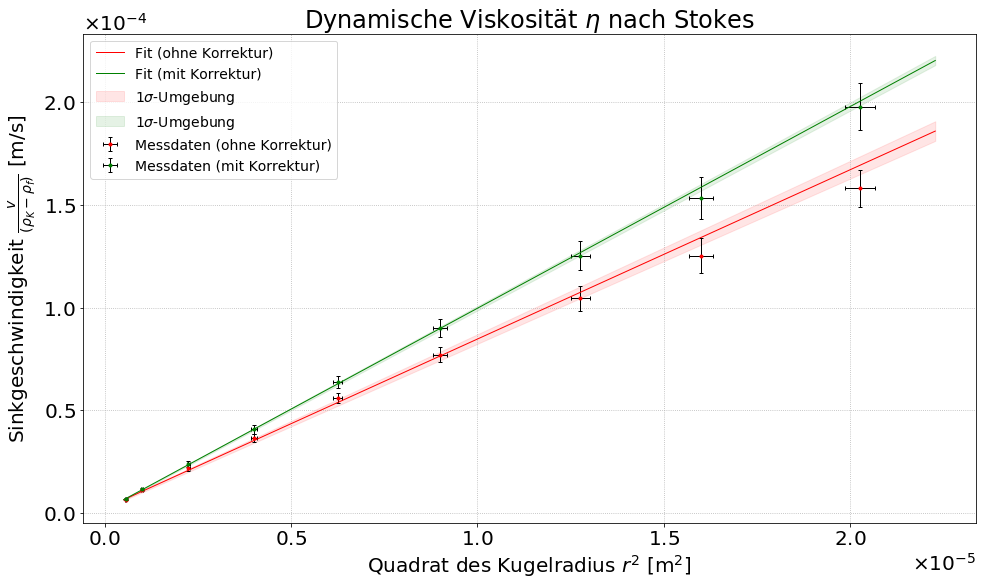


Dynamische Viskosität:

(ohne Korrektur): eta =  0.265 ± 0.006
(mit Korrektur):  eta =  0.222 ± 0.002
sigma = 24.921


In [7]:
x, dx = (d/2)**2, 2*d/4 *d_err # [mm^2]
y, dy = v/(rho_K - rho_Fl), dv/(rho_K - rho_Fl)
y_korr, dy_korr = v_korr/(rho_K - rho_Fl), dv_korr/(rho_K - rho_Fl)

def fit_func(p, x):
        (s,a) = p 
        return s*x+a

def fit(x,dx,y,dy,c,name,para0,fit_func,plt_range):
    
    from scipy import odr
    model = odr.Model(fit_func)
    
    x = x
    y = y
    delta_x = dx
    delta_y = dy
    
    #Startparameter
    para0 = para0
    
    data = odr.RealData(x, y, sx=delta_x, sy=delta_y)
    odr = odr.ODR(data, model, beta0=para0)
    out = odr.run()

    #1-Sigma
    popt = out.beta
    perr = out.sd_beta

    #Sigma-Umgebung
    nstd = 1 # um n-Sigma-Umgebung im Diagramm zu zeichnen

    popt_top = popt+nstd*perr
    popt_bot = popt-nstd*perr

    #Plot-Umgebung
    x_fit = np.linspace(min(x)/plt_range, max(x)*plt_range, 1000)
    fit = fit_func(popt, x_fit)
    fit_top = fit_func(popt_top, x_fit)
    fit_bot = fit_func(popt_bot, x_fit)

    plt.errorbar(x, y, xerr=delta_x, yerr=delta_y, lw=1, ecolor='k', mec=c, mfc=c, fmt='.', capsize=2,
                 label='Messdaten '+name)
    plt.plot(x_fit, fit, color=c, lw=1, label='Fit '+name)
    plt.fill_between(x_fit, fit_top, fit_bot, color=c, alpha=.1, 
                     label=str(nstd)+r'$\sigma$'+'-Umgebung')
    print('\nFitgüte '+ name+ ':\n')
    fitgüte(x,y,delta_x,delta_y,popt,fit_func) #[:-3] 
    return popt, perr

popt, perr = fit(x,dx,y,dy,
                 'r','(ohne Korrektur)',[1,1],fit_func,1.1)
popt_korr, perr_korr = fit(x,dx,y_korr,dy_korr,
                           'g','(mit Korrektur)',[1,1],fit_func,1.1)

#Auswertung
def Eta(popt,perr):
    S = popt[0]
    dS = perr[0]
    eta = 2*g/(9*S)
    deta = 2*g/(9*S**2)* dS
    return eta, deta

eta, deta = Eta(popt,perr)
eta_korr, deta_korr = Eta(popt_korr, perr_korr)
print('')
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,5), useMathText=True)
plt.title('Dynamische Viskosität $\eta$ nach Stokes')
plt.xlabel('Quadrat des Kugelradius $r^2$ [m$^2$]')
plt.ylabel('Sinkgeschwindigkeit $\\frac{v}{(\\rho_K - \\rho_f)}$ [m/s]')
plt.grid(ls=':')
plt.legend(loc='best',fontsize=14)
plt.show()

print('\nDynamische Viskosität:\n')
print('(ohne Korrektur): eta = ', form(eta,deta))
print('(mit Korrektur):  eta = ', form(eta_korr,deta_korr))
print('sigma =',sig(eta,deta,eta_korr,deta_korr))

\begin{align}
    \eta_\text{Stokes} &= 0.265 \pm 0.006 \ \text{[Pas]}\\
    \eta_\text{Stokes}^\text{korr} &= 0.222 \pm 0.002 \ \text{[Pas]}\\
    &\Rightarrow 24.92\sigma
\end{align}

Die zwei Werte für die dynamische Viskosität $\eta$ sind signifikant voneinander verschieden. Daraus lässt sich schließen, dass die Ladenburg-Korrektur sicher relevant für die spätere Analyse sein wird. Außerdem ist die Geringe Fitgüte auffällig, nach der das verwendete lineare Modell sich nicht wirklich anwenden lässt. Wir vermuten das dies mit der turbulenz der Strömung um die Kugel zu tun hat, wir wollen daher im folgenden Abschnitt die Reynoldszahl berechnen und sehen ob diese an irgendeinem Punkt den theoretischen kritischen Wert von $Re_\text{kr} \approx 1$ überschreitet. 

### Reynoldszahl $Re$

Die Reynoldszahl ist Systemabhängig und wird deshalb für jede Kugel einzeln berechnet nach:

\begin{align}
    Re &= \frac{\rho_f \bar{v} d}{\eta}\\
    \Delta Re &= \sqrt{\left( \frac{\bar{v} d}{\eta} \cdot \Delta \rho_f \right)^2 + \left( \frac{\rho_f d}{\eta} \cdot \Delta \bar{v} \right)^2 + \left( \frac{\rho_f \bar{v}}{\eta} \cdot \Delta d \right)^2 + \left( \frac{\rho_f \bar{v} d}{\eta^2} \cdot \Delta \eta\right)^2}
\end{align}

In [8]:
def Reynolds(v,dv,eta,deta):
    Re = rho_Fl*v*d/eta
    dRe = np.sqrt(((v*d/eta)*drho_Fl)**2
                  +((rho_Fl*d/eta)*dv)**2
                  +((rho_Fl*v/eta)*d_err)**2
                  +((rho_Fl*v*d/eta**2)*deta)**2)
    return Re, dRe

Re, dRe =  Reynolds(v,dv,eta,deta)
print('\nReynoldszahl:\n')
for i in range(0,len(Re),1):
    print('Re_'+str(i+1)+' =', format_e(Re[i]), '±', format_e(dRe[i]))
print('')


Reynoldszahl:

Re_1 = 1.040699e-02 ± 6.247361e-04
Re_2 = 2.186202e-02 ± 1.1481e-03
Re_3 = 6.524055e-02 ± 4.517925e-03
Re_4 = 1.452851e-01 ± 8.79424e-03
Re_5 = 2.767932e-01 ± 1.392713e-02
Re_6 = 4.57959e-01 ± 2.53184e-02
Re_7 = 7.379946e-01 ± 4.597509e-02
Re_8 = 9.044512e-01 ± 6.546316e-02
Re_9 = 1.313952e+00 ± 8.306316e-02



Man sieht dass an zwei stellen der Wert der Raynoldszahl dem theoretisch kritischen Wert sehr nahe kommen bzw. gar überschreiten. An dieser Stelle muss davon ausgegangen werden dass hier die umströmung der Kugel von laminar in turbulent übergeht. Somit unser Modell (Stokes) für die Berechnung der dynamischen Viskosität an Gültigkeit verliert. 

### Bestimmung der Kritischen Raynoldszahl $Re_{kr}$

Um die sache genauer zu untersuchen Wollen wir den genauen Punkt wissen an dem die Strömung in unserem Fall von laminar in turbulent übergeht. Wir suchen dazu einen Punkt, an dem die theoretische laminargeschwindigkeit $v_\text{lam}$ verglichen mit der von uns indirekt gemessenen, korregierten (Ladenburg) Geschwindigkeit $v_\text{korr}$ kleiner ist. Das bedeutet nähmlich dass die Kugel langsamer fällt als sie sollte, es treten dann höhere Reibungskräfte auf, als vom Laminarstrommodell vorhergesagt, es muss also Turbulenzen geben, welche die Kugelk zusätzlich verlangsamen. 


Fitgüte laminare Strömung:

chi_squared= 0.7261897859946586
chi_squared_red= 0.12103163099910975
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten: 99.4 %

Fitgüte turbulente Strömung:

chi_squared= 0.0
chi_squared_red= inf
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten: 100 %



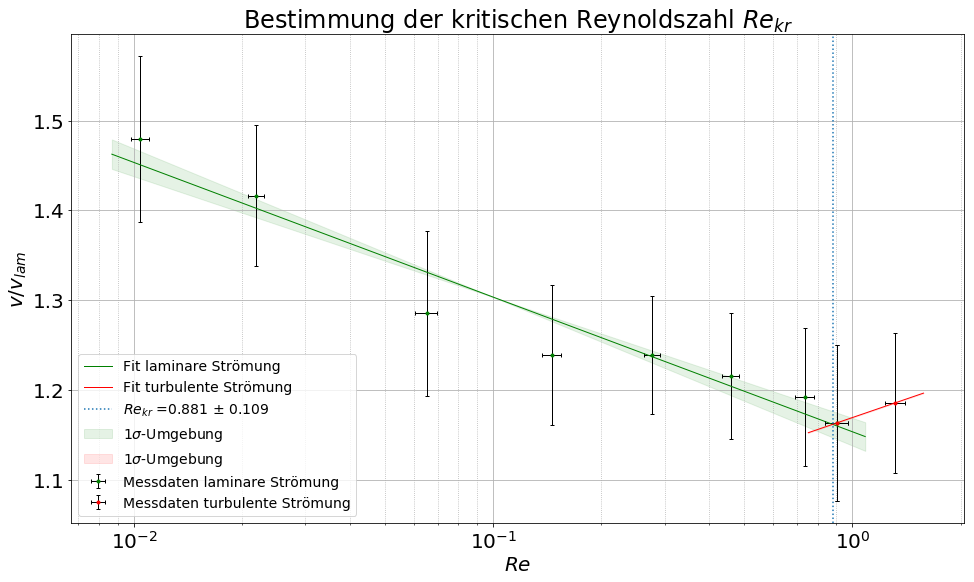


Kristische Reynoldszahl:

Re_kr = 8.80761e-01 ± 1.088258e-01
Re_kr_theo = 1.000 ± 0.000
sigma 1.201



In [9]:
def v_lam(d,d_err,rho_K,drho_K):
    r, dr = d/2, d_err/2
    v_lam = 2/9*g*(rho_K - rho_Fl)/eta *r**2
    dv_lam = np.sqrt(((2/9*g/eta *r**2)*drho_Fl)**2
                     +((2/9*g/eta *r**2)*drho_K)**2
                     +((2/9*g*(rho_K - rho_Fl)/eta**2 *r**2)*deta)**2
                     +((4/9*g*(rho_K - rho_Fl)/eta *r)*dr)**2)
    return v_lam, dv_lam
v_lam, dv_lam = v_lam(d,d_err,rho_K,drho_K)

v_v_lam = v_korr/v_lam
dv_v_lam = np.sqrt((1/v_lam *dv_korr)**2
                   +(v_korr/v_lam**2 * dv_lam)**2)

def fit_func(p, x):
        (s,a) = p 
        return s*np.log(x)+a
breakpoint = 7

popt1, perr1 = fit(Re[0:breakpoint+1],dRe[0:breakpoint+1],v_v_lam[0:breakpoint+1],dv_v_lam[0:breakpoint+1],
    'g','laminare Strömung',[1,1],fit_func,1.2)
popt2, perr2 = fit(Re[breakpoint:],dRe[breakpoint:],v_v_lam[breakpoint:],dv_v_lam[breakpoint:],
    'r','turbulente Strömung',[1,1],fit_func,1.2)

def intersect(m1,m2,b1,b2,fm1,fm2,fb1,fb2):
    xi = np.exp((b1-b2) / (m2-m1))
    dxi = np.sqrt((xi/(m2-m1)*fb1)**2+(xi/(m2-m1)*fb2)**2
                  +((b1-b2)*xi/((m2-m1)**2)*fm2)**2
                  +((b2-b1)*xi/((m2-m1)**2)*fm1)**2)
    
    yi = m1 * xi + b1
    return xi, dxi

Re_kr, dRe_kr = intersect(popt1[0],popt2[0],popt1[1],popt2[1],
                                    perr1[0],perr2[0],perr1[1],perr2[1])
print()
plt.title('Bestimmung der kritischen Reynoldszahl ${Re}_{kr}$')
plt.axvline(Re_kr,ls=':',label='$Re_{kr}$ ='+form(Re_kr,dRe_kr))
plt.xscale('log')
plt.grid(which='major')
plt.grid(which='minor', linestyle=':')
plt.xlabel('$Re$')
plt.ylabel('$v/v_{lam}$')
plt.legend(loc='best',fontsize=14)
plt.show()

print('\nKristische Reynoldszahl:\n')
print('Re_kr =',format_e(Re_kr), '±', format_e(dRe_kr))
print('Re_kr_theo =', form(1,0))
print('sigma', sig(Re_kr,dRe_kr,1,0))
print('')

\begin{align}
    Re_\text{kr} &= 0.968 \pm 0.117 \\
    Re_\text{kr}^\text{theo} &= 1.000 \pm 0.000 \\
    &\Rightarrow 0.075\sigma
\end{align}

Zu erkennen ist dass die Kugeln mit Radius $R=9$ und $7$ [mm] außerhalb des laminaren Bereiches sind. Dies hat allerdings zur Folge das die in Teil $REFERENCE$ Berechnete Viskosität an zwei Werten verfälscht worden ist. Wir wollen diese also nocheinmal untersuchen um zu sehen ob diese Verfälschung aufgrund der turbulenten Strömung signifikant ist oder nicht.

### Dynamische Viskosität $\eta$ nach Stokes ohne Turbulenzen.


Fitgüte (ohne Korrektur):

chi_squared= 6.2292064099083735
chi_squared_red= 0.8898866299869105
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten: 51.300000000000004 %

Fitgüte (mit Korrektur):

chi_squared= 1.0059155260052681
chi_squared_red= 0.14370221800075259
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten: 99.5 %

Fitgüte (ohne Turbulenz):

chi_squared= 0.6409833025595533
chi_squared_red= 0.12819666051191064
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten: 98.6 %



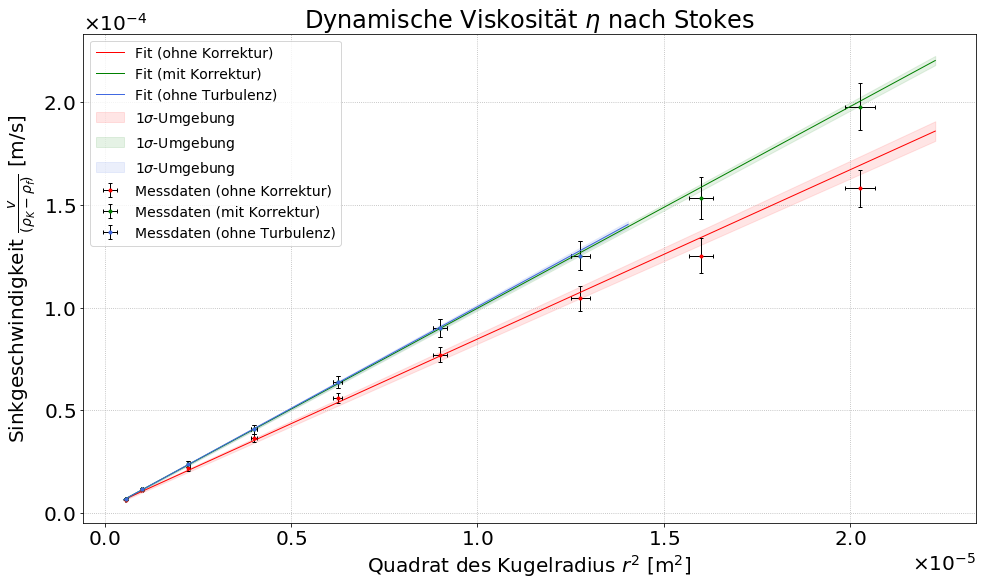


Dynamische Viskosität:

(mit Korrektur):   eta =  0.222 ± 0.002
(ohne Turbulenz):  eta =  0.220 ± 0.002
sigma = 0.185


In [10]:
x_re, dx_re = x[:breakpoint], dx[:breakpoint]
y_re, dy_re = y_korr[:breakpoint], dy_korr[:breakpoint]

def fit_func(p, x):
        (s,a) = p 
        return s*x+a


popt, perr = fit(x,dx,y,dy,
                 'r','(ohne Korrektur)',[1,1],fit_func,1.1)
popt_korr, perr_korr = fit(x,dx,y_korr,dy_korr,
                           'g','(mit Korrektur)',[1,1],fit_func,1.1)    
popt_re, perr_re = fit(x_re,dx_re,y_re,dy_re,
                 'royalblue','(ohne Turbulenz)',[1,1],fit_func,1.1)
    
eta_re, deta_re = Eta(popt_re, perr_re)
print('')
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,5), useMathText=True)
plt.title('Dynamische Viskosität $\eta$ nach Stokes')
plt.xlabel('Quadrat des Kugelradius $r^2$ [m$^2$]')
plt.ylabel('Sinkgeschwindigkeit $\\frac{v}{(\\rho_K - \\rho_f)}$ [m/s]')
plt.grid(ls=':')
plt.legend(loc='best',fontsize=14)
plt.show()

print('\nDynamische Viskosität:\n')
print('(mit Korrektur):   eta = ', form(eta_korr,deta_korr))
print('(ohne Turbulenz):  eta = ', form(eta_re,deta_re))
print('sigma =',sig(eta_re,deta_re,eta_korr,deta_korr))

Die Fitgüte hat sich minimal verschlechtert von $99.5 \%$ auf $98.6\%$. Es scheint also weitere Parameter geben die Unser modell unvollständig machen, darauf soll in der Diskussion noch konkreter eingegangen werden. Der Wert für die erhaltene Viskosität hat sich nicht großartig verändert. Die 

## Teil 2: Kapillarviskosimeter

Nach dem Gesetz von Hagen-Poiseuille ergibt sich für die Durchflussmenge $Q$ durch ein Rohr:

\begin{align}
    \frac{dV}{dt} &= Q = \int_0^R 2\pi r \cdot v(r)\ dr \\
    &= \frac{\pi(p_1 - p_2)R^4}{8 \eta L}\\
    &= \frac{\pi \rho_f g (h_1 - h_2)R^4}{8 \eta L}\\
    &\Rightarrow \eta = \frac{\pi \rho_f g (h_1 - h_2)R^4}{8 Q L}
\end{align}

### Berechnen der Durchflussmenge $Q$


Fitgüte Durchflussmenge:

chi_squared= 1.594228902355326
chi_squared_red= 0.3985572255888315
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten: 81.0 %



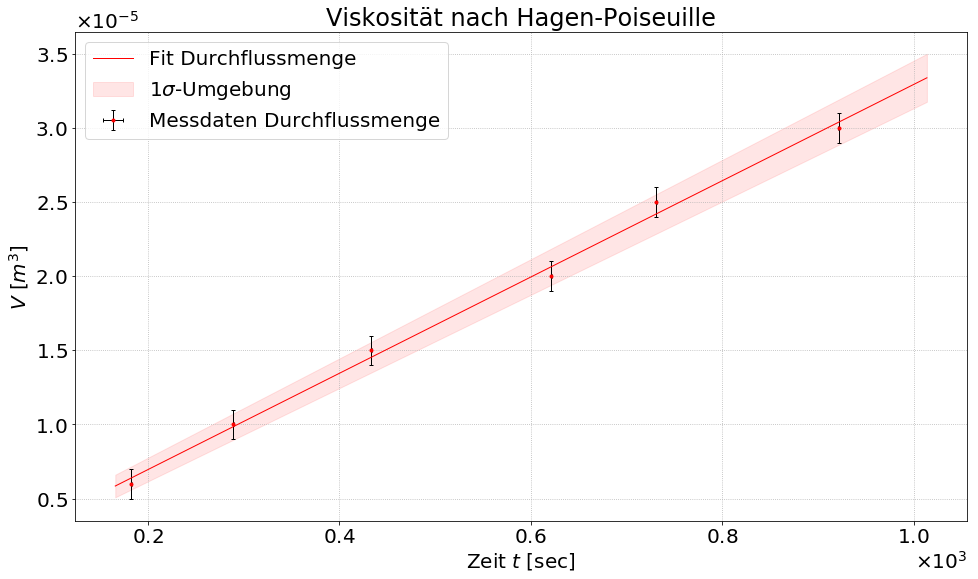


Durchflussmenge:

Q = 2.086656e-01 ± 8.700698e-03  [m^3/sec]



In [16]:
V = np.array([6,10,15,20,25,30]) *1e-6 # abgetropftes Volumen [m^3]
dV = np.full(V.size,1) *1e-6

t2 = np.array([182.82,289.40,433.36,621.56,731.22,921.68]) # Zeit [sec]
dt2 = np.full(t2.size,0.5) 

R = 1.5 *1e-3 /2 # Kapillarradius [m]
dR = 0.01 *1e-3 /2

L = 100 *1e-3 # Kapillarlänge [m]
dL = 0.5 *1e-3 

h1 = 490 *1e-3 #Anfangshöhe [m]
dh1 = 2 *1e-3

h2 = 480 *1e-3 # Endhöhe [m]
dh2 = 2 *1e-3

h_mean = (h1 + h2)/2
dh_mean = np.sqrt((dh2)**2+(dh1)**2)

def fit_func(p, x):
    (s,a) = p 
    return s*x+a

popt, perr = fit(t2,dt2,V,dV,'r','Durchflussmenge',[1,1],fit_func,1.1)
Q, dQ = popt[0], perr[0]
print()
plt.ticklabel_format(axis='both', style='sci', scilimits=(0,3), useMathText=True)
plt.grid(ls=':')
plt.title('Viskosität nach Hagen-Poiseuille')
plt.xlabel('Zeit $t$ [sec]')
plt.ylabel('$V$ [$m^3$]')
plt.legend(loc='best')
plt.show()

eta2 = np.pi*(rho_Fl*h_mean*g)*(R**4)/(8*L*Q)
deta2 = np.sqrt((((np.pi*(h_mean*g)*(R**4)/(8*L*Q))*drho_Fl)**2)
                +((np.pi*(rho_Fl*g)*(R**4)/(8*L*Q))*dh_mean)**2
                +((4*np.pi*(rho_Fl*h_mean*g)*(R**3)/(8*L*Q))*dR)**2
                +((np.pi*(rho_Fl*h_mean*g)*(R**4)/(8*L**2*Q))*dL)**2
                +((np.pi*(rho_Fl*h_mean*g)*(R**4)/(8*L*Q**2))*dQ)**2)

print('\nDurchflussmenge:\n')
print('Q =', format_e(eta2), '±', format_e(deta2), ' [m^3/sec]')
print('')

### Berechnung der dynamischen Viskosität $\eta$ nach Hagen-Poiseuille

In [17]:
print('\nViskosität nach Hagen-Poiseuille:\n')
print('eta_HP =',form(eta2,deta2))
print('eta_Stokes =', form(eta_re,deta_re))
print('sigma', sig(eta2,deta2,eta_re,deta_re))
print('')


Viskosität nach Hagen-Poiseuille:

eta_HP = 0.209 ± 0.009
eta_Stokes = 0.220 ± 0.002
sigma 1.087



\begin{align}
    \eta_\text{HP} &= 0.210 \pm 0.009 \ \text{[Pa s]}\\
    \eta_\text{Stokes} &= 0.206 \pm 0.006 \ \text{[Pa s]}\\
    &\Rightarrow 0.057\sigma
\end{align}

Die Ergebnisse stimmen sehr gut überein und sind mit einer $\sigma$-Abweichung von $0.27 < 3$ nicht signifikant voneinander verschieden.

### Bestimmung der Reynoldszahl $Re_\text{Ka}$ in der Kapillare 

In [18]:
Re2 = 2*rho_Fl*Q/(np.pi*R*eta2)
dRe2 = np.sqrt(((2*Q/(np.pi*R*eta2))*drho_Fl)**2
                    +((2*rho_Fl/(np.pi*R*eta2))*dQ)**2
                    +((2*rho_Fl*Q/(np.pi*R**2*eta2))*dR)**2
                    +((2*rho_Fl*Q/(np.pi*R*eta2**2))*deta2)**2)

print('\nReynoldszahl Kapillare:\n')
print('Re_Ka =',form(Re2,dRe2))
print('Re_Ka_kr =', form(2300,0))
print('sigma = ',sig(Re2,dRe2,2300,0))
print()


Reynoldszahl Kapillare:

Re_Ka = 0.152 ± 0.008
Re_Ka_kr = 2300.000 ± 0.000
sigma =  83675853212.436



Die von uns gemessen Reynoldszahl für das verwendete Kapillarsystem beträgt $Re_\text{Ka} \approx 0.15 \ll  Re_{kr} \approx 2300$. Die Strömung verhält sich somit mit hoher Sicherheit laminar.